In [1]:
import os
os.chdir('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

In [2]:
df_train = pd.read_csv('data/clean/clean_data_train.csv', index_col=False)

df_train['team1'] = df_train['team1'].map(lambda l: l.replace(' ', ''))
df_train['team2'] = df_train['team2'].map(lambda l: l.replace(' ', ''))

In [3]:
df_train.head()


,team1,team1score,team2,team2score,match_type,match_stage,player0_id,player0_rating,player0_kd,player1_id,...,player7_kd,player8_id,player8_rating,player8_kd,player9_id,player9_rating,player9_kd,team1_Ranking,team2_Ranking,team_1_won
0,FaZe,0,Spirit,3,BO5,GF,9960.0,1.16,1.14,11816.0,...,1.06,18317,1.07,1.04,7716.0,0.99,0.93,2.0,14.0,0
1,Spirit,2,Falcons,0,BO3,SF,21167.0,1.46,1.47,16920.0,...,1.05,11777,1.05,1.02,922.0,0.83,0.73,14.0,11.0,1
2,MOUZ,0,FaZe,2,BO3,SF,18850.0,1.13,1.23,13666.0,...,1.13,8183,1.11,1.02,429.0,0.94,0.83,5.0,2.0,0
3,ENCE,1,Falcons,2,BO3,QF,16848.0,1.20,1.36,19114.0,...,1.14,11777,1.07,1.05,922.0,0.86,0.76,48.0,11.0,0
4,FaZe,2,G2,0,BO3,QF,9960.0,1.16,1.17,11816.0,...,0.92,9618,0.96,0.89,10096.0,0.89,0.76,2.0,6.0,1


In [4]:
### We will create embeddings for team Name and Player ID
team_name_list = pd.concat([df_train['team1'], df_train['team2']]).unique()

player_id_list = pd.concat([df_train[f'player{i}_id'] for i in range(10)]).unique()


In [5]:
from sklearn.preprocessing import LabelEncoder

team_name_enc = LabelEncoder()
team_name_enc.fit(team_name_list)
df_train['team1'] = team_name_enc.transform(df_train['team1'])
df_train['team2'] = team_name_enc.transform(df_train['team2'])


player_enc = LabelEncoder()
player_enc.fit(player_id_list)
for i in range(10):
    df_train[f'player{i}_id'] = player_enc.transform(df_train[f'player{i}_id'])

mt_enc = LabelEncoder()
mt_enc.fit(df_train['match_type'])
df_train['match_type'] = mt_enc.transform(df_train['match_type'])

ms_enc = LabelEncoder()
ms_enc.fit(df_train['match_stage'])
df_train['match_stage'] = ms_enc.transform(df_train['match_stage'])

In [7]:
numerical_features = ['team1_Ranking', 'team2_Ranking']
for i in range(10):
    numerical_features.append(f'player{i}_rating')
    numerical_features.append(f'player{i}_kd')

text_features = ['team1', 'team2', 'match_type', 'match_stage']
for i in range(10):
    text_features.append(f'player{i}_id')

X_numerical = df_train[numerical_features]

X_text = df_train[text_features]

y = df_train['team_1_won']

In [8]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(X_text, X_numerical, y, test_size=0.2, random_state=42)

X_text_train_list = []
for text_feat in text_features:
    X_text_train_list.append(X_text_train[text_feat])

X_text_val_list = []
for text_feat in text_features:
    X_text_val_list.append(X_text_val[text_feat])

In [9]:
X_text_train

,team1,team2,match_type,match_stage,player0_id,player1_id,player2_id,player3_id,player4_id,player5_id,player6_id,player7_id,player8_id,player9_id
354,9,14,1,0,310,308,178,277,309,278,319,53,318,180
234,22,39,1,0,134,221,38,269,193,220,292,82,290,248
3,20,27,1,2,168,228,146,17,151,47,249,229,87,2
18,27,53,1,0,47,229,249,87,2,303,298,326,270,299
131,16,44,1,0,43,173,156,89,31,260,226,230,137,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,26,30,1,0,88,197,67,26,1,231,8,9,60,68
106,17,24,0,0,39,103,123,110,86,147,100,99,4,73
270,61,44,1,2,91,160,202,47,15,25,226,230,63,137
348,34,17,1,0,79,196,130,24,96,110,123,184,103,86


In [10]:
from tensorflow.keras.layers import Dense, Embedding, BatchNormalization, ReLU, Concatenate, Flatten
from tensorflow.keras import Input, Model

def get_model(layers = [64,64,64]):
    input = Input(shape = (22, ))
    h = Dense(layers[0])(input)
    h = BatchNormalization()(h)
    h = ReLU()(h)
    for layer in layers[1:-2]:
        h = Dense(layer)(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)
    h = Dense(layers[-1])(h)
    h = BatchNormalization()(h)
    h = ReLU()(h)
    output = Dense(1, activation = 'sigmoid')(h) ## returns logits
    model = Model(inputs = input, outputs = output)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss = loss, optimizer = 'adam')
    return model

In [61]:
from tensorflow.keras.callbacks import EarlyStopping


callback = EarlyStopping(patience = 500, restore_best_weights = True) ## 100 epoch patience for val loss


model = get_model([4096, 2048, 2048, 2048, 2048, 4096])
history = model.fit(X_numerical_train, y_train, epochs=10000, batch_size=64, validation_data=(X_numerical_val, y_val), verbose=False, callbacks=callback)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

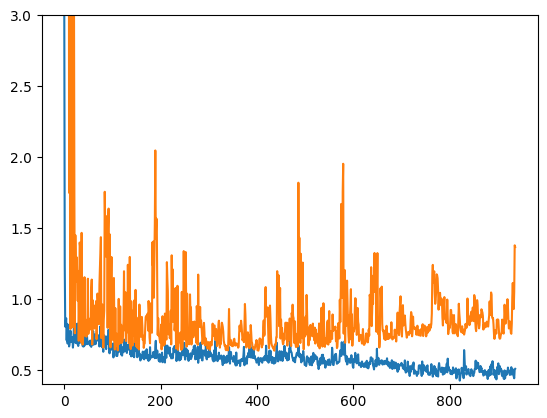

In [62]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.ylim([0.4,3])
plt.legend

In [63]:
preds = model.predict(X_numerical_val)

print('accuracy is ', np.mean((preds>0.5).squeeze() == y_val))
binCE_loss = tf.keras.losses.binary_crossentropy(y_val, preds)
print('Binary cross entropy is ', np.mean(binCE_loss))
probs = np.squeeze(preds)
print('Cross entropy score is ', -np.mean(np.log(probs)*y_val + np.log(1-probs)*(1-y_val)))


3/3 [==============================] - 0s 2ms/step
accuracy is  0.6419753086419753
Binary cross entropy is  0.7566071
Cross entropy score is  0.6364681028105594


In [69]:
def get_full_model(embed_dim=32, layer_dims = [64, 64, 64]):
    team_embedding = Embedding(len(team_name_enc.classes_), embed_dim)
    player_embedding = Embedding(len(player_enc.classes_), embed_dim)
    match_type_embedding = Embedding(len(mt_enc.classes_), embed_dim)
    match_stage_embedding = Embedding(len(ms_enc.classes_), embed_dim)

    ## get inputs for each text feature
    t1 = Input(shape = (1))
    t2 = Input(shape = (1))
    mt = Input(shape = (1))
    ms = Input(shape = (1))
    p0 = Input(shape=(1))
    p1 = Input(shape=(1))
    p2 = Input(shape=(1))
    p3 = Input(shape=(1))
    p4 = Input(shape=(1))
    p5 = Input(shape=(1))
    p6 = Input(shape=(1))
    p7 = Input(shape=(1))
    p8 = Input(shape=(1))
    p9 = Input(shape=(1))

    ## Embed each text feature
    t1_embed = Flatten()(team_embedding(t1))
    t2_embed = Flatten()(team_embedding(t2))
    mt_embed = Flatten()(match_type_embedding(mt))
    ms_embed = Flatten()(match_stage_embedding(ms))
    p0_embed = Flatten()(player_embedding(p0))
    p1_embed = Flatten()(player_embedding(p1))
    p2_embed = Flatten()(player_embedding(p2))
    p3_embed = Flatten()(player_embedding(p3))
    p4_embed = Flatten()(player_embedding(p4))
    p5_embed = Flatten()(player_embedding(p5))
    p6_embed = Flatten()(player_embedding(p6))
    p7_embed = Flatten()(player_embedding(p7))
    p8_embed = Flatten()(player_embedding(p8))
    p9_embed = Flatten()(player_embedding(p9))

    
    numerical_input = Input(shape = (22))

    ## Concatenate all features
    embeddings_concat = Concatenate()([t1_embed, t2_embed, mt_embed, ms_embed, p0_embed, p1_embed, p2_embed, p3_embed, p4_embed, p5_embed, p6_embed, p7_embed, p8_embed, p9_embed, numerical_input])
    # embeddings_concat = Concatenate()([t1_embed, t2_embed, mt_embed, ms_embed, numerical_input])

    h = Dense(layer_dims[0])(embeddings_concat)
    h = BatchNormalization()(h)
    h = ReLU()(h)
    for layer in layer_dims[1:-2]:
        h = Dense(layer)(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)
    h = Dense(layer_dims[-1])(h)
    h = BatchNormalization()(h)
    h = ReLU()(h)
    output = Dense(1, activation = 'sigmoid')(h)

    model = Model(inputs = (t1, t2, mt, ms, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, numerical_input), outputs = output)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss = loss, optimizer = 'adam')
    return model

In [65]:
model = get_full_model()
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_213 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_214 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_215 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_216 (InputLayer)         [(None, 1)]          0           []                               
                                                                                           

In [74]:
callback = EarlyStopping(patience = 100, restore_best_weights = True) ## 100 epoch patience for val loss

X_train_concat = [X_text_train_list[i] for i in range(len(text_features))] + [X_numerical_train]
X_val_concat = [X_text_val_list[i] for i in range(len(text_features))] + [X_numerical_val]

model = get_full_model(32,[10000, 10000, 10000])
history = model.fit(X_train_concat, y_train, epochs=2500, batch_size=64, validation_data=(X_val_concat, y_val), verbose=False, callbacks= callback)

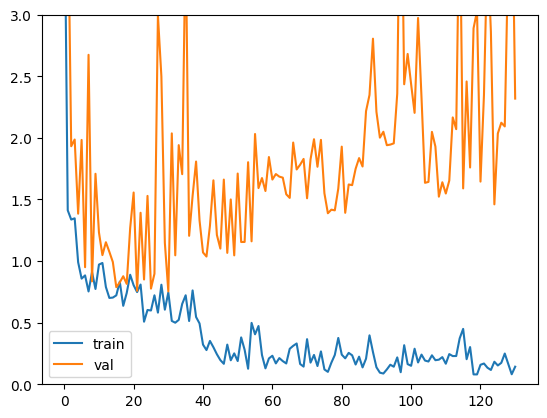

In [75]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.ylim([0,3])
plt.legend()

In [76]:
preds = model.predict(X_val_concat)

print('accuracy is ', np.mean((preds>0.5).squeeze() == y_val))
binCE_loss = tf.keras.losses.binary_crossentropy(y_val, preds)
print('Binary cross entropy is ', np.mean(binCE_loss))
probs = np.squeeze(preds)
print('Cross entropy score is ', -np.mean(np.log(probs)*y_val + np.log(1-probs)*(1-y_val)))


3/3 [==============================] - 0s 3ms/step
accuracy is  0.5925925925925926
Binary cross entropy is  1.1039395
Cross entropy score is  0.7540352249257181


In [77]:
preds

array([[8.4071708e-01],
       [4.8286682e-01],
       [7.9037112e-01],
       [9.2898273e-01],
       [8.9937061e-01],
       [1.3414914e-02],
       [7.4097556e-01],
       [2.0008786e-01],
       [2.2658747e-01],
       [1.1502115e-01],
       [3.7159964e-01],
       [3.4931401e-04],
       [7.9670262e-01],
       [7.7256143e-01],
       [8.0699205e-01],
       [4.4444915e-02],
       [5.0957185e-01],
       [4.7068709e-01],
       [8.3749086e-01],
       [2.9932046e-01],
       [7.3843855e-01],
       [5.3631777e-01],
       [9.2881608e-01],
       [8.2349461e-01],
       [5.0634090e-02],
       [2.0033273e-01],
       [4.8248923e-01],
       [9.1530615e-01],
       [2.4228254e-02],
       [5.2013051e-02],
       [9.3168193e-01],
       [3.1555411e-01],
       [6.9310822e-02],
       [7.1778065e-01],
       [1.3111751e-01],
       [8.9811099e-01],
       [4.1552907e-01],
       [4.6314928e-01],
       [1.3842966e-02],
       [9.6636492e-01],
       [1.8104498e-01],
       [6.764621

In [78]:
print(-np.log(0.5))

0.6931471805599453


In [80]:
print('accuracy is ', np.mean(0 == y_val))


accuracy is  0.5185185185185185
